# Algorithm 1 VAE 
This is the first algorithm of the paper for Variational AutoEncoder

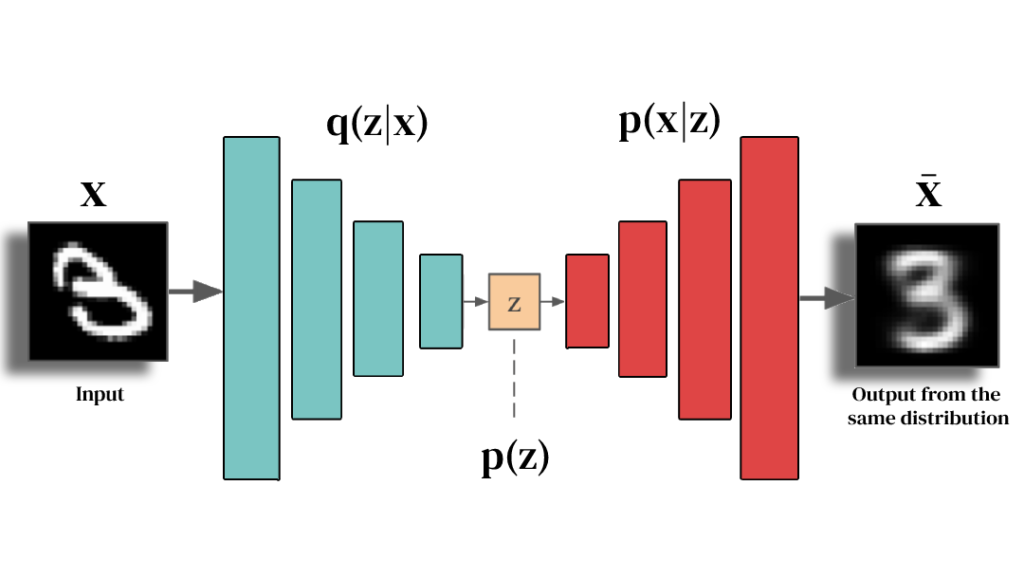

We model each pixel value $\in \{0,1\}$ as a sample drawn from a Bernoulli distribution. Through a decoder, the latent random variable $z_n$  associated with an image $n$ is mapped to the success parameters of the Bernoulli distributions associated with the pixels of that image. Our generative model is described as follows:

$ z_n \sim N(0,I) $

$ \theta_n = g(z_n) $

$ x_n \sim Bern(\theta_n) $

where $g$ is the decoder. We choose the prior on $z_n$ to be the standard multivariate normal distribution, for computational convenience.  

**Inference model:** We infer the posterior distribution of $z_n$ via variational inference. The variational distribution $ q(z_n|x_n) $ is chosen to be multivariate Gaussian with a diagonal covariance matrix. The mean and covariance of this distribution are obtained by applying an encoder to $x_n$.

$ q(z_n|x_n) \sim q( \mu_n, \sigma^2_n) $

where $ \mu_n, \sigma^2_n = f(x_n)  $ and $f$ is the encoder.


In [165]:
import torch
import torch.nn as nn
import torch.distributions as dist

import numpy as np

from tqdm import tqdm

# Do not change the seeds
torch.manual_seed(0)
np.random.seed(0)


if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")


dataset_path = '~/datasets'

batch_size = 128

# Dimensions of the input, the hidden layer, and the latent space.
x_dim  = 784
hidden_dim = 200
latent_dim = 20

# Learning rate
lr = 1e-4

# Number of epoch
epochs = 20

Using device: mps


In [166]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])


train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)
test_labels = test_dataset.targets

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

In [167]:
class Encoder(nn.Module):
    # encoder outputs the parameters of variational distribution "q"
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_enc1 = nn.Linear(input_dim, hidden_dim) # FC = fully connected layer
        self.FC_enc2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_std  = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_1     = self.LeakyReLU(self.FC_enc1(x))
        h_2     = self.LeakyReLU(self.FC_enc2(h_1))
        mu    = self.FC_mean(h_2)  # mean / location
        log_var = self.FC_std(h_2)   # log variance

        return mu, log_var

In [168]:
class Decoder(nn.Module):
    # decoder generates the success parameter of each pixel
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_dec1   = nn.Linear(latent_dim, hidden_dim)
        self.FC_dec2   = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, z):
        h_out_1  = self.LeakyReLU(self.FC_dec1(z))
        h_out_2  = self.LeakyReLU(self.FC_dec2(h_out_1))

        theta = torch.sigmoid(self.FC_output(h_out_2))
        return theta


In [169]:
class Model(nn.Module):
    # it wrap the encoder and the decoder
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, std):
        # 1. Sample standard normal noise epsilon: epsilon ~ N(0, I)
        # Use torch.randn_like(mean) to ensure 'eps' has the same size and device
        # as 'mean' (or 'std').
        eps = torch.randn_like(mean)
        z = mean + eps * std
        return z

    def forward(self, x):
        # insert your code here
        mean, log_var = self.Encoder.forward(x)
        
        std = torch.sqrt(torch.exp(log_var))
        
        z = self.reparameterization(mean, std)
        
        theta = self.Decoder.forward(z)
        return theta, mean, log_var, z

In [170]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder)

model.to(device)

Model(
  (Encoder): Encoder(
    (FC_enc1): Linear(in_features=784, out_features=200, bias=True)
    (FC_enc2): Linear(in_features=200, out_features=200, bias=True)
    (FC_mean): Linear(in_features=200, out_features=20, bias=True)
    (FC_std): Linear(in_features=200, out_features=20, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (Decoder): Decoder(
    (FC_dec1): Linear(in_features=20, out_features=200, bias=True)
    (FC_dec2): Linear(in_features=200, out_features=200, bias=True)
    (FC_output): Linear(in_features=200, out_features=784, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)

In [171]:
def loss_function(x, theta, mean, log_var): # should return the loss function (- ELBO)
    eps = 1e-9

    log_px_z = x * torch.log(theta + eps) + (1 - x) * torch.log(1 - theta + eps)
    log_px_z = log_px_z.sum(dim=1)
    recon_term = log_px_z.mean(dim=0)

    var = torch.exp(log_var)
    m_kl_per_sample = 0.5 * torch.sum(1 + log_var -var - mean.pow(2), dim=1)
    m_kl_term = m_kl_per_sample.mean(dim=0)

    elbo = recon_term + m_kl_term
    loss = -elbo
    return loss

In [172]:
from torch.optim import Adam

print("Start training VAE...")
model.train()

# optimizer
optimizer = Adam(model.parameters(), lr=lr)
pbar = tqdm(range(epochs))
elbo_1 = []
for epoch in pbar:
    total_loss = 0
    total_samples = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        x = x.view(-1, x_dim)
        x = torch.round(x)

        optimizer.zero_grad()

        # insert your code here
        theta, mean, log_var,_= model.forward(x)
        
        loss = loss_function(x,theta,mean,log_var)
        loss.backward()
        optimizer.step()

        # loss.item() is the mean. Multiply by batch size to get the sum.
        total_loss += loss.item() * x.size(0)
        total_samples += x.size(0)

    # Correct global average
    avg_loss = total_loss / total_samples

    pbar.set_description(f"Epoch {epoch+1}/{epochs},"
                         f" Loss: {avg_loss:.4f},"
                         f" ELBO: {-avg_loss:.4f}")
    elbo_1.append(-avg_loss)

print("Finish!!")

Start training VAE...


Epoch 20/20, Loss: 106.7578, ELBO: -106.7578: 100%|██████████| 20/20 [05:39<00:00, 17.00s/it]

Finish!!


# Algorithm 2 VAE - Sticking the Landing

In [173]:
class Model(nn.Module):
    # it wrap the encoder and the decoder
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, std):
        # 1. Sample standard normal noise epsilon: epsilon ~ N(0, I)
        # Use torch.randn_like(mean) to ensure 'eps' has the same size and device
        # as 'mean' (or 'std').
        eps = torch.randn_like(mean)
        z_pathwise = mean + eps * std
        
        z_stop_grad = z_pathwise.detach()
        
        return z_pathwise,z_stop_grad

    def forward(self, x):
        # insert your code here
        mean, log_var = self.Encoder.forward(x)
        
        std = torch.sqrt(torch.exp(log_var))
        
        z_pathwise,z_stop_grad = self.reparameterization(mean, std)
        
        theta = self.Decoder.forward(z_stop_grad)
        return theta, mean, log_var, z_pathwise,z_stop_grad

In [174]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model= Model(Encoder=encoder, Decoder=decoder)

model.to(device)

Model(
  (Encoder): Encoder(
    (FC_enc1): Linear(in_features=784, out_features=200, bias=True)
    (FC_enc2): Linear(in_features=200, out_features=200, bias=True)
    (FC_mean): Linear(in_features=200, out_features=20, bias=True)
    (FC_std): Linear(in_features=200, out_features=20, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (Decoder): Decoder(
    (FC_dec1): Linear(in_features=20, out_features=200, bias=True)
    (FC_dec2): Linear(in_features=200, out_features=200, bias=True)
    (FC_output): Linear(in_features=200, out_features=784, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)

In [175]:
def loss_function(x, theta, mean, log_var): # should return the loss function (- ELBO)
    eps = 1e-9

    log_px_z = x * torch.log(theta + eps) + (1 - x) * torch.log(1 - theta + eps)
    log_px_z = log_px_z.sum(dim=1)
    recon_term = log_px_z.mean(dim=0)

    var = torch.exp(log_var)
    m_kl_per_sample = 0.5 * torch.sum(1 + log_var -var - mean.pow(2), dim=1)
    m_kl_term = m_kl_per_sample.mean(dim=0)

    elbo = recon_term + m_kl_term
    loss = -elbo
    return loss

In [ ]:
from torch.optim import Adam

print("Start training VAE...")
model.train()

# optimizer
optimizer = Adam(model.parameters(), lr=lr)
pbar = tqdm(range(epochs))
elbo_2= []
for epoch in pbar:
    total_loss = 0
    total_samples = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        x = x.view(-1, x_dim)
        x = torch.round(x)

        optimizer.zero_grad()

        # insert your code here
        theta_ng, mean, log_var,_,_= model.forward(x)
        
        loss = loss_function(x,theta_ng,mean,log_var) # it is computed by detaching z, so we pass the theta_ng
        loss.backward()
        optimizer.step()

        # loss.item() is the mean. Multiply by batch size to get the sum.
        total_loss += loss.item() * x.size(0)
        total_samples += x.size(0)

    # Correct global average
    avg_loss = total_loss / total_samples

    pbar.set_description(f"Epoch {epoch+1}/{epochs},"
                         f" Loss: {avg_loss:.4f},"
                         f" ELBO: {-avg_loss:.4f}")
    elbo_2.append(-avg_loss)

print("Finish!!")

Start training VAE...


Epoch 3/20, Loss: 207.6454, ELBO: -207.6454:  15%|█▌        | 3/20 [00:49<04:28, 15.80s/it]

# Comparison
Comparing the ELBO over iterations for the standard VAE and the modified VAE of algorithm 2.

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

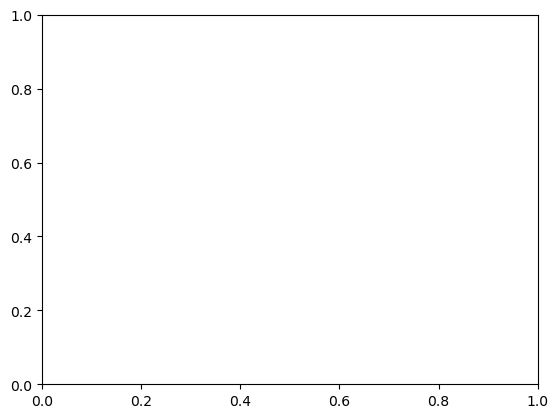

In [ ]:
# Plot ELBO curve
import matplotlib.pyplot as plt
plt.plot(range(1, epochs + 1), elbo_1)
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.title('ELBO Algorithm 1 over Epochs')
plt.show()

# Plot ELBO curve
import matplotlib.pyplot as plt
plt.plot(range(1, epochs + 1), elbo_2)
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.title('ELBO Algorithm 2 over Epochs')
plt.show()


# Final ELBO
print(f"Final ELBO for Algorithm 1: {elbo_1[-1]}")
print(f"Final ELBO for Algorithm 2: {elbo_2[-1]}")